In [1]:
from benchmark import benchmark

### Bechmarks for collection of data from simulations and calculation of metrics

below is an example of benchmark for collection of data from website u.gg. More detailed guide about how to use this benchmark can be found in the README.md file.

In [ ]:
# u.gg
benchmark(
{
    "benchmark_name": "experiment_data",
    "simulations": [

        {
            "provider" : "openai",
            "model" : "gpt-4-turbo",
            "request_rate": 30,
            "verbose": "true",
            "initial_timout": 3,
            "cookie_config": {
                "buttons": [
                    {
                        "type": "class",
                        "name": "fc-button-label"
                    }
                ]
            },
            "website": "https://u.gg/lol/champions",
            "website_name_short": "u.gg",
            "goal": "Find counters for Ahri",
            "target_urls": ["https://u.gg/lol/champions/ahri/build", "https://u.gg/lol/champions/ahri/counter"],
            "final_action": "Retrieve",
            "runs": 1
        }
    ]}
)

In [ ]:
# rottentomatoes example
benchmark(
{
    "benchmark_name": "experiment_data",
    "simulations":[
    {
        "runs" : 1,
        "target_urls": ["https://en.wikipedia.org/wiki/Monty_Python_and_the_Holy_Grail"],
        "final_action": "Retrieve",
        "website": "https://www.rottentomatoes.com/",
        "goal": "Find name of a director of a film Monty Python and the Holy Grail",
        "request_rate": 30,
        "website_name_short" : "rottentomatoes",
        "personna": "None",
        "llm_provider": "openai",
        "model": "gpt-4-turbo",
        "temperature": 0.45,
        "verbose": "true",
        "initial_timeout": 3,
        "timeout_per_action": 0,
        "web_data": {
            "type": "class",
            "name": "search-text"
        },
        "cookie_config": {
            "buttons": [
                {
                    "type": "id",
                    "name": "onetrust-reject-all-handler"
                }
            ]
        }
    }
    ]
}
)

## Output of benchmarks

the output is stored in a file hierarchy described in the README.md file. The data are then used to create plots and tables.

In [2]:
import json
def side_file_parser(file : str) -> list[dict]:
    # open file as json
    with open(file, 'r') as f:
        data = json.load(f)

    parsed_data_raw = []

    for command in data["tests"][0]["commands"]:

        data_action = {}

        data_action["current_url"] = data["url"]
        data_action["name"] = file
        data_action["command"] = {}
        data_action["command"]["action_type"] = command["command"]
        data_action["command"]["target"] = command["target"]
        data_action["command"]["value"] = command["value"]
        data_action["command"]["targets"] = command["targets"]

        ignored_commands = ["open", "setWindowSize","runScript","mouseOver","selectFrame","selectWindow","storeWindowHandle","mouseOut","close","mouseOut","mouseDownAt","mouseMoveAt","mouseUpAt"]

        if command["command"] in ignored_commands:
            continue

        parsed_data_raw.append(data_action)

    annotation_file = file.replace(".side", ".txt")

    with open(annotation_file, 'r') as f:
        data = f.read().split("\n")

        if len(data) != len(parsed_data_raw):
            raise ValueError("Number of actions and number of timestamps do not match")

        for i in range(len(parsed_data_raw)):
            parsed_data_raw[i]["timestamp"] = data[i].split("|")[0].strip()
            parsed_data_raw[i]["timestamp"] = int(parsed_data_raw[i]["timestamp"])
            parsed_data_raw[i]["current_url"] = data[i].split("|")[1].strip()


    return parsed_data_raw

In [3]:
def calculate_metrics_for_human_data(parsed_data : list[dict]) -> dict:

    metrics = {}

    metrics["current_url"] = parsed_data[0]["current_url"]
    metrics["action_count"] = len(parsed_data)
    metrics["click_count"] = len([x for x in parsed_data if x["command"]["action_type"] in ["click","doubleClick"]])
    metrics["simulation_length"] = parsed_data[-1]["timestamp"] - parsed_data[0]["timestamp"]
    metrics["average_time_per_action"] = metrics["simulation_length"] / metrics["action_count"]
    metrics["raw_data"] = parsed_data

    return metrics

In [6]:
exp_data = {"experiment_data":{}}

In [7]:
import os
import json



def parse_data(directory_path : str) -> dict:

    parsed_data = {}

    directories = os.listdir(directory_path)

    for directory in directories:
        parsed_data[directory] = {}
        subdirectories = os.listdir(directory_path+directory)
        for subdirectory in subdirectories:
            parsed_data[directory][subdirectory] = {}
            files = os.listdir(directory_path+directory+"/"+subdirectory)
            local_data = {"success_rate": 0,
             "average_actions_per_simulation":0,
             "average_simulation_time" : 0.0,
             "average_time_per_action": 0.0,
             "raw_data" : []
             }
            for file in files:
                if file.endswith(".json"):

                    with open(directory_path+directory+"/"+subdirectory+"/"+file) as f:
                        data = json.load(f)
                        # store the data in the local dictionary
                        if data["goal_complete"]:
                            local_data["success_rate"] += 1
                        local_data["average_simulation_time"] += data["simulation_length"]
                        local_data["average_actions_per_simulation"] += data["action_count"]
                        local_data["average_time_per_action"] += data["average_time_per_action"]
                        local_data["raw_data"].append(data["raw_data"])

            for key in local_data.keys():
                if key == "raw_data":
                    continue
                local_data[key] = local_data[key]/len(files)
                local_data[key] = round(local_data[key], 3)

            parsed_data[directory][subdirectory] = local_data

    return parsed_data


exp_data = parse_data("./experiment_data/")

In [8]:
# define color scheme for matplotlib bar charts
colors = {
    "gpt-3.5-turbo": "#005083",
    "gpt-4-turbo": "#9f8a89",
    "mistral": "#f0b64d",
    "user_data": "#6876a4",
}

In [9]:
def calculate_average_success_rate(selected_model):
    average = 0
    for website in exp_data[selected_model].keys():
        average += exp_data[selected_model][website]["success_rate"]

    average = average / len(exp_data[selected_model].keys())

    return round(average, 3)


In [10]:
avg_gpt_4_turbo = calculate_average_success_rate("gpt-4-turbo")
avg_gpt_35_turbo = calculate_average_success_rate("gpt-3.5-turbo")

print("GPT 4 Turbo AVG success:",avg_gpt_4_turbo,"\nGPT 3.5 Turbo AVG success:",avg_gpt_35_turbo)

GPT 4 Turbo AVG success: 0.821 
GPT 3.5 Turbo AVG success: 0.463


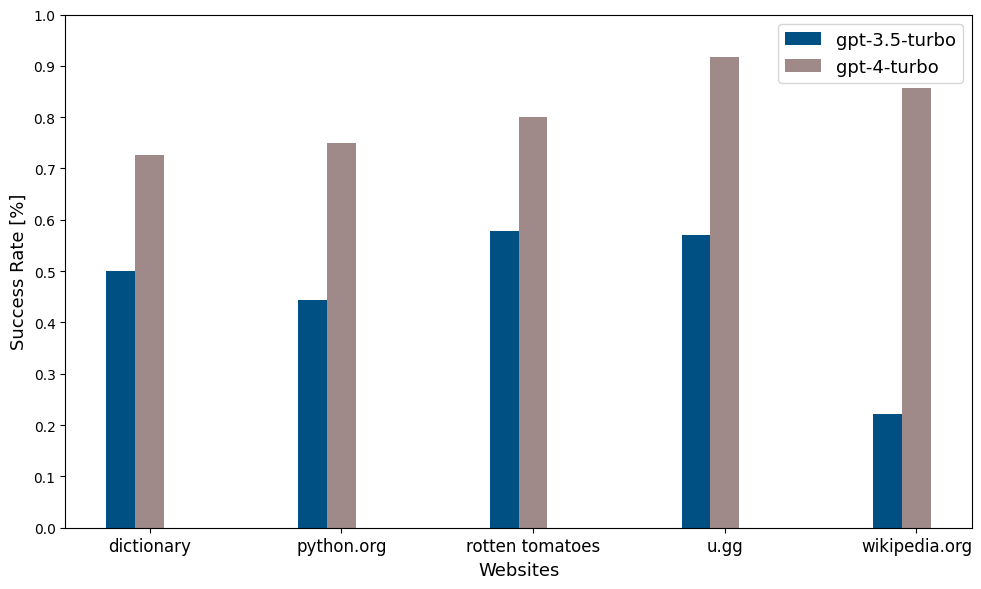

In [11]:
import matplotlib.pyplot as plt
import numpy as np



def plot_success_rate(data, filename):
    models = list(data.keys())
    websites = list(data[models[0]].keys())
    num_models = len(models)
    num_websites = len(websites)
    bar_width = 0.15
    index = np.arange(num_websites)

    plt.figure(figsize=(10, 6))

    for i, model in enumerate(models):
        successes = [data[model][website]["success_rate"] for website in websites]
        plt.bar(index + i * bar_width, successes, bar_width, label=model, color=colors[model] )

    plt.xlabel('Websites', fontsize=13)
    plt.ylabel('Success Rate [%]', fontsize=13)
    plt.xticks(index + bar_width * num_models / 2, websites, fontsize=12)


    plt.legend(fontsize=13)
    plt.yticks(np.arange(0,1.1,0.1),fontsize=10)
    plt.ylim(0, 1)
    plt.tight_layout()
    if filename is None:
        plt.show()
    else:
        plt.savefig(filename, format='pdf')

plot_success_rate(exp_data, "figures/success_rate.pdf")

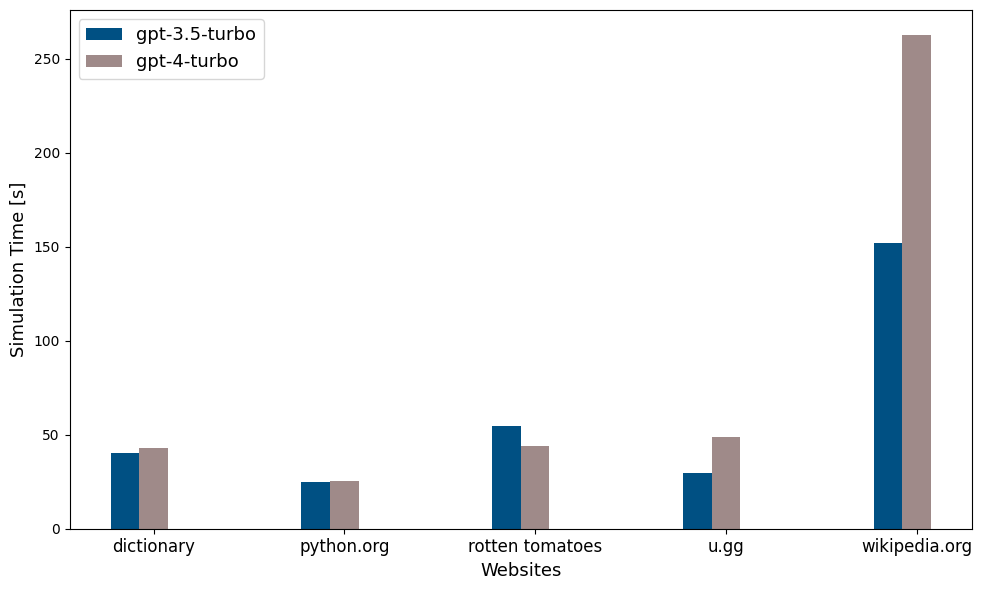

In [12]:
def plot_simulation_time(data, filename):
    models = list(data.keys())
    websites = list(data[models[0]].keys())
    num_models = len(models)
    num_websites = len(websites)
    bar_width = 0.15  # Width of the bars
    index = np.arange(num_websites)  # Index for the websites

    plt.figure(figsize=(10, 6))  # Adjust the figure size here

    for i, model in enumerate(models):
        simulation_times = [data[model][website]["average_simulation_time"] for website in websites]
        plt.bar(index + i * bar_width, simulation_times, bar_width, label=model, color=colors[model])

    plt.xlabel('Websites', fontsize=13)
    plt.ylabel('Simulation Time [s]', fontsize=13)
    plt.xticks(index + bar_width * num_models / 2, websites, fontsize=12)  # Position the x-axis ticks
    plt.legend(fontsize=13)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    if filename is None:
        plt.show()
    else:
        plt.savefig(filename, format='pdf')  # Save the plot as PDF

plot_simulation_time(exp_data, "figures/simulation_time.pdf")

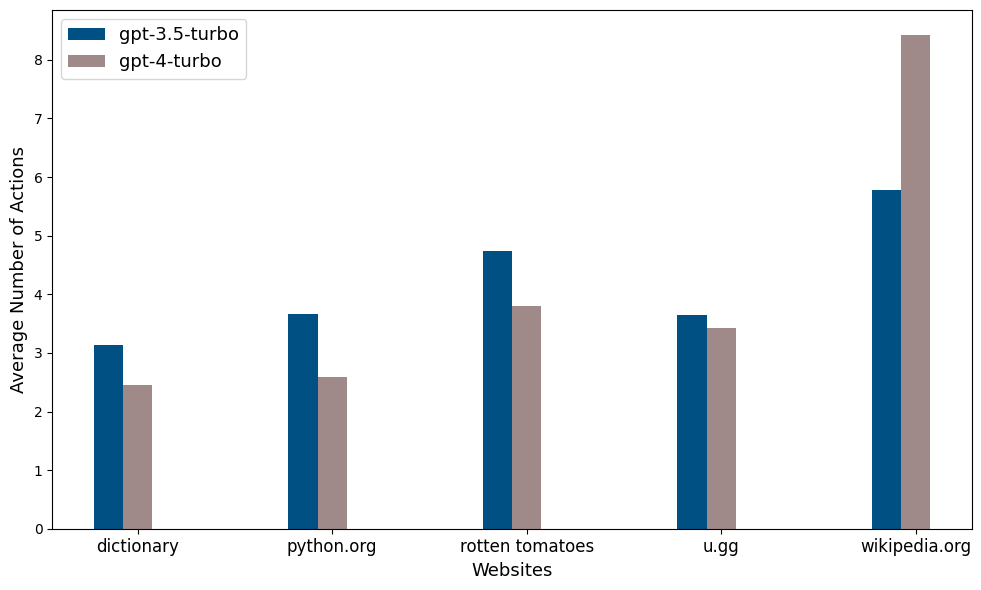

In [13]:
def plot_actions_count(data, filename):
    models = list(data.keys())
    websites = list(data[models[0]].keys())
    num_models = len(models)
    num_websites = len(websites)
    bar_width = 0.15
    index = np.arange(num_websites)

    plt.figure(figsize=(10, 6))

    for i, model in enumerate(models):
        actions = [data[model][website]["average_actions_per_simulation"] for website in websites]
        plt.bar(index + i * bar_width, actions, bar_width, label=model, color=colors[model])

    plt.xlabel('Websites', fontsize=13)
    plt.ylabel('Average Number of Actions', fontsize=13)
    plt.xticks(index + bar_width * num_models / 2, websites, fontsize=12)
    plt.legend(fontsize=13)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    if filename is None:
        plt.show()
    else:
        plt.savefig(filename, format='pdf')

plot_actions_count(exp_data, "figures/actions_count.pdf")

In [14]:
# parse all wikipedia files
import os



human_data = {"wikipedia": []}


for file in os.listdir("data_humans/raw_data/wikipedia"):
    if file.endswith(".side"):
        parsed_data = side_file_parser("data_humans/raw_data/wikipedia/"+file)
        human_data["wikipedia"].append(calculate_metrics_for_human_data(parsed_data))


human_data["python"] = []


for file in os.listdir("data_humans/raw_data/python"):
    if file.endswith(".side"):
        parsed_data = side_file_parser("data_humans/raw_data/python/"+file)
        human_data["python"].append(calculate_metrics_for_human_data(parsed_data))

human_data["dictionary"] = []

for file in os.listdir("data_humans/raw_data/dictionary"):
    if file.endswith(".side"):
        parsed_data = side_file_parser("data_humans/raw_data/dictionary/"+file)
        human_data["dictionary"].append(calculate_metrics_for_human_data(parsed_data))

human_data["rotten tomatoes"] = []

for file in os.listdir("data_humans/raw_data/rottentomatoes"):
    if file.endswith(".side"):
        parsed_data = side_file_parser("data_humans/raw_data/rottentomatoes/"+file)
        human_data["rotten tomatoes"].append(calculate_metrics_for_human_data(parsed_data))

human_data["u.gg"] = []

for file in os.listdir("data_humans/raw_data/ugg"):
    if file.endswith(".side"):
        parsed_data = side_file_parser("data_humans/raw_data/ugg/"+file)
        human_data["u.gg"].append(calculate_metrics_for_human_data(parsed_data))


def calculate_averages(human_data : list[dict]) -> dict:
    averages = {}

    averages["raw_data"] = [x["raw_data"] for x in human_data]

    averages["average_actions_per_simulation"] = sum([x["action_count"] for x in human_data]) / len(human_data)
    averages["click_count"] = sum([x["click_count"] for x in human_data]) / len(human_data)
    averages["average_simulation_time"] = sum([x["simulation_length"] for x in human_data]) / len(human_data)
    averages["average_time_per_action"] = sum([x["average_time_per_action"] for x in human_data]) / len(human_data)


    return averages

calculate_averages(human_data["wikipedia"])
calculate_averages(human_data["python"])


exp_data["user_data"] = {}

exp_data["user_data"]["wikipedia.org"] = calculate_averages(human_data["wikipedia"])
exp_data["user_data"]["python.org"] = calculate_averages(human_data["python"])
exp_data["user_data"]["dictionary"] = calculate_averages(human_data["dictionary"])
exp_data["user_data"]["rotten tomatoes"] = calculate_averages(human_data["rotten tomatoes"])
exp_data["user_data"]["u.gg"] = calculate_averages(human_data["u.gg"])


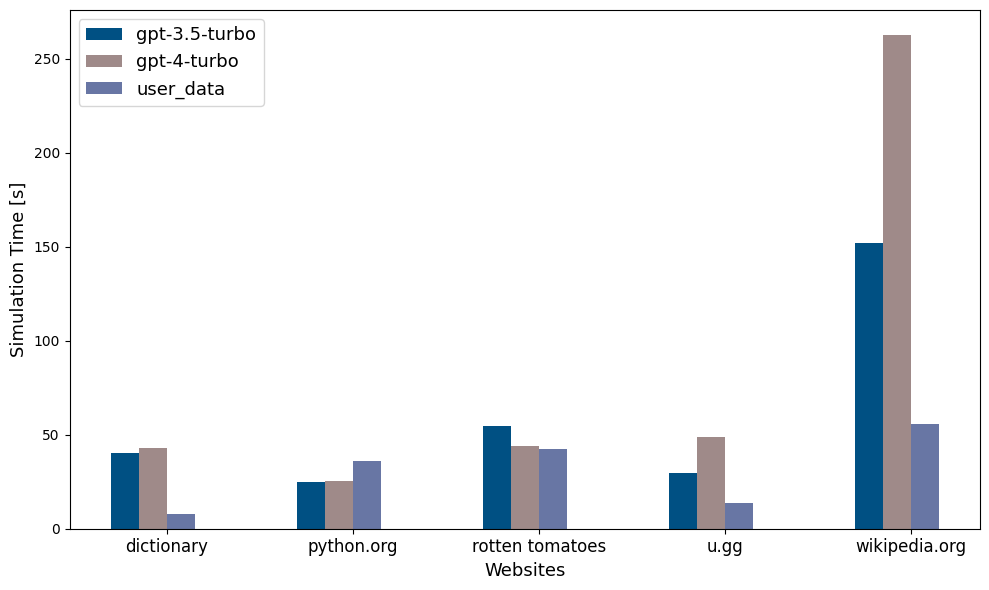

In [15]:
# simulation time comparison between humans and all models
def plot_simulation_time_comparison(data, filename):
    models = list(data.keys())
    websites = list(data[models[0]].keys())
    num_models = len(models)
    num_websites = len(websites)
    bar_width = 0.15
    index = np.arange(num_websites)

    plt.figure(figsize=(10, 6))

    for i, model in enumerate(models):
        simulation_times = [data[model][website]["average_simulation_time"] for website in websites]
        plt.bar(index + i * bar_width, simulation_times, bar_width, label=model, color=colors[model])

    plt.xlabel('Websites', fontsize=13)
    plt.ylabel('Simulation Time [s]', fontsize=13)

    plt.xticks(index + bar_width * num_models / 2, websites, fontsize=12)
    plt.legend(fontsize=13)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    if filename is None:
        plt.show()
    else:
        plt.savefig(filename, format='pdf')

plot_simulation_time_comparison(exp_data, "figures/simulation_time_comparison.pdf")

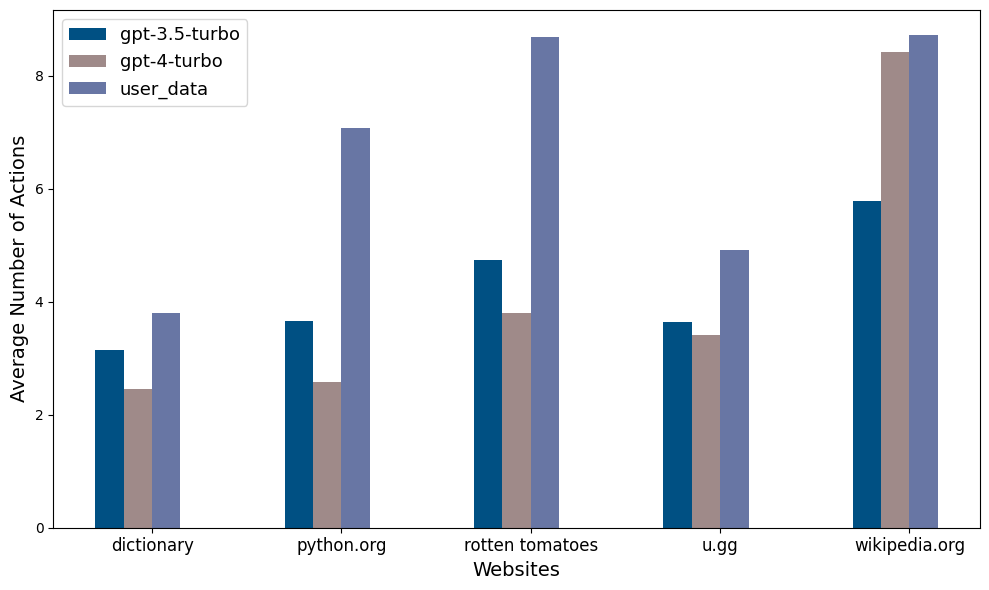

In [16]:
# actions count comparison between humans and all models





def plot_actions_count_comparison(data, filename):
    models = list(data.keys())
    websites = list(data[models[0]].keys())
    num_of_models = len(models)
    num_of_websites = len(websites)
    bar_width = 0.15
    index = np.arange(num_of_websites)

    plt.figure(figsize=(10, 6))

    for i, model in enumerate(models):
        actions = [data[model][website]["average_actions_per_simulation"] for website in websites]
        plt.bar(index + i * bar_width, actions, bar_width, label=model, color=colors[model])


    plt.xlabel('Websites', fontsize=14)
    plt.ylabel('Average Number of Actions', fontsize=14)

    plt.xticks(index + bar_width * num_of_models / 2, websites, fontsize=12)
    plt.legend(fontsize=13)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    if filename is None:
        plt.show()
    else:
        plt.savefig(filename, format='pdf')  # Save the plot as PDF

plot_actions_count_comparison(exp_data, "figures/actions_count_comparison.pdf")

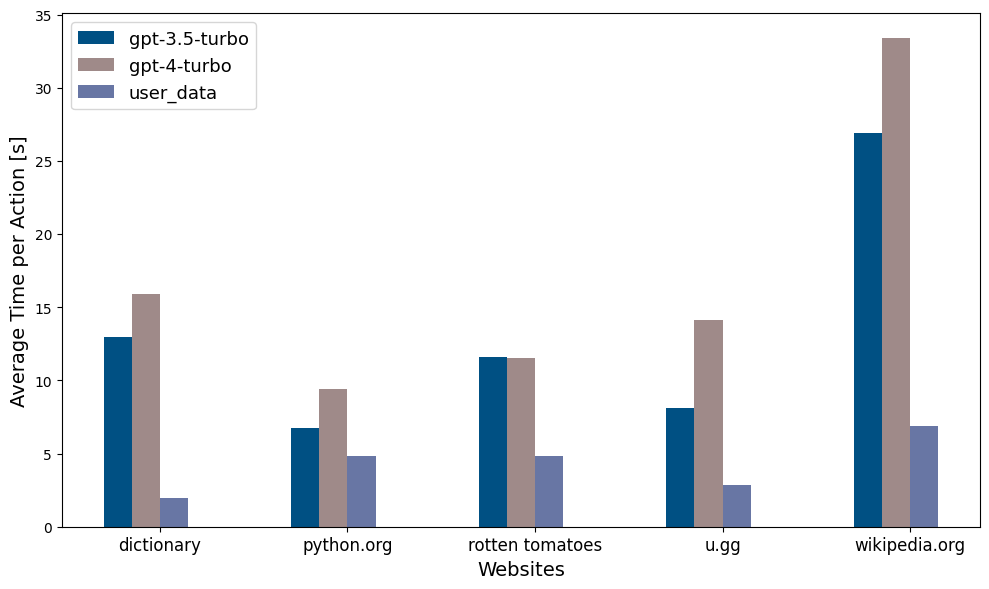

In [17]:
def plot_average_time_per_action_comparison(data, filename):
    models = list(data.keys())
    websites = list(data[models[0]].keys())
    num_of_models = len(models)
    num_of_websites = len(websites)
    bar_width = 0.15
    index = np.arange(num_of_websites)

    plt.figure(figsize=(10, 6))

    for i, model in enumerate(models):
        times = [data[model][website]["average_time_per_action"] for website in websites]
        plt.bar(index + i * bar_width, times, bar_width, label=model, color=colors[model])

    plt.xlabel('Websites', fontsize=14)
    plt.ylabel('Average Time per Action [s]', fontsize=14)
    plt.xticks(index + bar_width * num_of_models / 2, websites, fontsize=12)
    plt.legend(fontsize=13)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    if filename is None:
        plt.show()
    else:
        plt.savefig(filename, format='pdf')  # Save the plot as PDF

plot_average_time_per_action_comparison(exp_data, "figures/average_time_per_action_comparison.pdf")

In [18]:
"""
source:
Vaibhav Bajpai,
"Remove adjacent duplicate elements from a list [duplicate]",
Modified 1 year, 10 months. Stack Overflow.
https://stackoverflow.com/questions/3460161/remove-adjacent-duplicate-elements-from-a-list
"""
def remove_adjacent(nums):
  i = 1
  while i < len(nums):
    if nums[i] == nums[i-1]:
      nums.pop(i)
      i -= 1
    i += 1
  return nums

def parser_llm_sankey (data_web: dict):
    unique_urls = []
    for raw_data in data_web["raw_data"]:
        for action in raw_data:
            if not action["current_url"] in unique_urls:
                unique_urls.append(action["current_url"])
    print(unique_urls)

    urls_per_simulation = [[action["current_url"] for action in raw_data] for raw_data in data_web["raw_data"]]
    print(urls_per_simulation)
    urls = [remove_adjacent(url) for url in urls_per_simulation]

    sankey_data = {}
    sankey_data["nodes"] = unique_urls
    sankey_data["links"] = urls

    return sankey_data


def shorten_url_for_sankey_data(data: dict, url_lookup_dict: dict) -> dict:
    i = 0
    for node in data["nodes"]:
        if i != 0:
            for key in url_lookup_dict.keys():
                data["nodes"][i] = data["nodes"][i].replace(key,url_lookup_dict[key])
        i += 1


    for i in range(len(data["links"])):
        for j in range(len(data["links"][i])):
            for key in url_lookup_dict.keys():
                data["links"][i][j] = data["links"][i][j].replace(key,url_lookup_dict[key])

    return data

def plot_sankey(data: dict, path: str, fontsize: int):
    sources = []
    targets = []
    values = []
    colors= []


    color_lookup_itensity = {90:"#ae017e",80:"#dd3497",70:"#f768a1",60:"#fa9fb5",50:"#fcc5c0",40:"#fde0dd",30:"#fff7f3",20:"#82cfff",10:"#bae6ff",0:"#e5f6ff"}


    for link in data["links"]:
        for i in range(len(link)-1):
            sources.append(data["nodes"].index(link[i]))
            targets.append(data["nodes"].index(link[i+1]))
            values.append(1)
            colors.append(color_lookup_itensity[(100 - (i+1)*10) % 100])

    import plotly.graph_objects as go

    fig = go.Figure(go.Sankey(
        arrangement='snap',
        node=dict(
            label=data["nodes"],
            align='left',
            thickness=15,
            line = dict(color = "black", width=1),


        ),
        link=dict(
            arrowlen=15,
            source=sources,
            target=targets,
            color=colors,
            value=values,
        )
    ))

    fig.update_layout(
        font_size=fontsize,
        font_color="blue",

    )

    fig.write_image(path)






### Sankey diagram for Wikipedia org

llm data here

In [19]:


data = parser_llm_sankey(exp_data["gpt-4-turbo"]["wikipedia.org"])

url_to_short = {
    "https://en.wikipedia.org":"",
    "Gymnasium_(school)#Czech_Republic_and_Slovakia": "Gymnasium_(school)...",
    "/wiki/Main_Page": "Main_Page",
    "/wiki/Special:Search?go=Go&search=Vacalv+Havel&ns0=1" : "Search...",
    "/wiki/Special:Search?go=Go&search=vaclav+havel&ns0=1" : "Search...",
    "/wiki/V%C3%A1clav_Havel#Early_life": "Early_life",
    "/wiki/V%C3%A1clav_Havel": "VaclavHavel",
    "/wiki/Vaclav_Havel" : "VaclavHavel",
}

data = shorten_url_for_sankey_data(data,url_to_short)

plot_sankey(data,"figures/sankey_wikipedia_llm.pdf",11)

['https://www.wikipedia.org/', 'https://en.wikipedia.org/wiki/Vaclav_Havel', 'https://en.wikipedia.org/wiki/V%C3%A1clav_Havel#Early_life', 'https://en.wikipedia.org/wiki/Main_Page', 'https://en.wikipedia.org/wiki/V%C3%A1clav_Havel', 'https://en.wikipedia.org/wiki/Gymnasium_(school)#Czech_Republic_and_Slovakia']
[['https://www.wikipedia.org/', 'https://www.wikipedia.org/', 'https://www.wikipedia.org/', 'https://www.wikipedia.org/', 'https://www.wikipedia.org/', 'https://en.wikipedia.org/wiki/Vaclav_Havel', 'https://en.wikipedia.org/wiki/V%C3%A1clav_Havel#Early_life', 'https://en.wikipedia.org/wiki/V%C3%A1clav_Havel#Early_life'], ['https://www.wikipedia.org/', 'https://www.wikipedia.org/', 'https://www.wikipedia.org/', 'https://www.wikipedia.org/', 'https://www.wikipedia.org/', 'https://www.wikipedia.org/', 'https://www.wikipedia.org/', 'https://www.wikipedia.org/', 'https://en.wikipedia.org/wiki/Vaclav_Havel', 'https://en.wikipedia.org/wiki/V%C3%A1clav_Havel#Early_life', 'https://en.wik

In [20]:
# human data

data = parser_llm_sankey(exp_data["user_data"]["wikipedia.org"])


url_to_short = {
    "https://en.wikipedia.org":"",
    "Gymnasium_(school)#Czech_Republic_and_Slovakia": "Gymnasium_(school)...",
    "/wiki/Special:Search?go=Go&search=Vacalv+Havel&ns0=1" : "Search...",
    "/wiki/Special:Search?go=Go&search=vaclav+havel&ns0=1" : "Search...",
    "/wiki/V%C3%A1clav_Havel#Early_life": "VaclavHavel#Early_life",
    "/wiki/V%C3%A1clav_Havel": "VaclavHavel",
}

data = shorten_url_for_sankey_data(data,url_to_short)

plot_sankey(data,"figures/sankey_wikipedia_human.pdf",11)

['https://www.wikipedia.org/', 'https://en.wikipedia.org/wiki/V%C3%A1clav_Havel', 'https://en.wikipedia.org/wiki/Special:Search?go=Go&search=Vacalv+Havel&ns0=1', 'https://en.wikipedia.org/wiki/Special:Search?go=Go&search=vaclav+havel&ns0=1']
[['https://www.wikipedia.org/', 'https://www.wikipedia.org/', 'https://en.wikipedia.org/wiki/V%C3%A1clav_Havel', 'https://en.wikipedia.org/wiki/V%C3%A1clav_Havel', 'https://en.wikipedia.org/wiki/V%C3%A1clav_Havel', 'https://en.wikipedia.org/wiki/V%C3%A1clav_Havel', 'https://en.wikipedia.org/wiki/V%C3%A1clav_Havel', 'https://en.wikipedia.org/wiki/V%C3%A1clav_Havel'], ['https://www.wikipedia.org/', 'https://www.wikipedia.org/', 'https://en.wikipedia.org/wiki/V%C3%A1clav_Havel', 'https://en.wikipedia.org/wiki/V%C3%A1clav_Havel', 'https://en.wikipedia.org/wiki/V%C3%A1clav_Havel', 'https://en.wikipedia.org/wiki/V%C3%A1clav_Havel'], ['https://www.wikipedia.org/', 'https://en.wikipedia.org/wiki/V%C3%A1clav_Havel', 'https://en.wikipedia.org/wiki/V%C3%A1cla

human data here

### Sankey diagram for Python.org

In [21]:
data = parser_llm_sankey(exp_data["gpt-4-turbo"]["python.org"])

url_to_short = {
    "https://www.python.org/events/":"/events/",
}

data = shorten_url_for_sankey_data(data,url_to_short)

plot_sankey(data,"figures/sankey_python_llm.pdf",11)

['https://www.python.org/', 'https://www.python.org/events/', 'https://www.python.org/events/python-events/1741/']
[['https://www.python.org/', 'https://www.python.org/'], ['https://www.python.org/', 'https://www.python.org/'], ['https://www.python.org/', 'https://www.python.org/'], ['https://www.python.org/', 'https://www.python.org/events/', 'https://www.python.org/events/'], ['https://www.python.org/', 'https://www.python.org/events/', 'https://www.python.org/events/'], ['https://www.python.org/', 'https://www.python.org/events/', 'https://www.python.org/events/'], ['https://www.python.org/', 'https://www.python.org/events/', 'https://www.python.org/events/'], ['https://www.python.org/', 'https://www.python.org/events/', 'https://www.python.org/events/'], ['https://www.python.org/', 'https://www.python.org/events/', 'https://www.python.org/events/'], ['https://www.python.org/', 'https://www.python.org/'], ['https://www.python.org/', 'https://www.python.org/events/python-events/1741/

In [22]:

data = parser_llm_sankey(exp_data["user_data"]["python.org"])

for links in data["links"]:
    for element in links:
        if element == "https://www.python.org/":
            # remove it from the list
            links.remove(element)
    if links[0] != "https://www.python.org/":
        links.insert(0,"https://www.python.org/")



url_to_short = {
    "https://www.python.org" : "...python.org",
    "...python.org/events/":".../events/",
    "...python.org/python-events/" : ".../python-events/",
    "...python.org/events/calendars/":"../events/calendars/..",
    "https://meetup.com/pyladies/events/300253273/" : "meetup.com/pyladies/",
    "...python.org/python-user-group/1756/" : ".../python-user-group/",
    ".../events/python-user-group/1719/" : "/events/pythonusergroup/",
    ".../events/python-user-group/1758/" : "/events/pythonusergroup/",
    ".../events/python-user-group/1760/" : "/events/pythonusergroup/",
    ".../events/python-user-group/1711/" : "/events/pythonusergroup/",
    ".../events/python-user-group/1761/" : "/events/pythonusergroup/",
    ".../events/python-user-group/1755/" : "/events/pythonusergroup/",
    "...python.org/search/?q=Netherlands&submit=" : ".../search/?q=...",
    ".../python-events/locations/1407/" : "/locations/",
    ".../python-events/1741/" : ".../python-events/",
    ".../python-events/1741/" : ".../python-events/",
    "...python.org/blogs/":".../blogs/",
    ".../events/python-events/1741/" : "events/python-events",
    "...python.org/search/?q=" : ".../search/?q=",
    ".../events//calendars/" : ".../events/calendars/",
    ".../events/python-events/?page=7" : ".../python-events/",
    ".../events/python-events/?page=6" : ".../python-events/",
    ".../events/python-events/?page=5" : ".../python-events/",
    ".../events/python-events/?page=4" : ".../python-events/",
    ".../events/python-events/?page=3" : ".../python-events/",
    ".../events/python-events/?page=2" : ".../python-events/",
    ".../events/python-events/?page=1" : ".../python-events/",
    ".../events/python-user-group/1756/" : "/events/pythonusergroup/",
    ".../python-events/1741/" : ".../python-events/",
    "...python.org/python-events/locations/1407/" : "/locations/",
    ".../python-user-group/1719/":".../python-user-group/",
    "...python.org/python-events/1741/" : ".../python-events/",
    "...python.org/events/python-user-group/1719/" : "/events/pythonusergroup/",
    "...python.org/events/python-user-group/1755/" : "/events/pythonusergroup/",
    "...python.org/python-events/" : ".../python-events/xxxx/",
    "https://python.org/python-events/1741/" : ".../python-events/",
    "https://python.org/python-events/locations/1407/" : "/locations/",
    "https://python.org/events/python-user-group/1755/" : "/events/pythonusergroup/",
    "https://python.org/events/python-user-group/1719/" : "/events/pythonusergroup/",
    ".../events/python-user-group/1757/" : "/events/pythonusergroup/",
    "https://lmorillas.github.io/python_events/" : "lmorillas.github.io",
    "https://python.org/python-events/" : ".../python-events/",
    "https://python.org/events/" : "/events/",
    "blog.python" : "blog.python.org/",
}

data["nodes"].insert(0,"https://www.python.org/events/")

data = shorten_url_for_sankey_data(data,url_to_short)

data["nodes"].pop(0)



plot_sankey(data,"figures/sankey_python_human.pdf",9)

['https://www.python.org/events/', 'https://www.python.org/events/python-events/', 'https://www.python.org/events/python-user-group/1756/', 'https://www.python.org/python-events/', 'https://www.python.org/events/python-events/?page=2', 'https://www.python.org/events/python-events/?page=3', 'https://www.python.org/events/python-events/?page=4', 'https://www.python.org/events/python-events/?page=5', 'https://www.python.org/events/python-events/?page=6', 'https://www.python.org/events/python-events/?page=7', 'https://www.python.org/events/calendars/', 'https://www.python.org', 'https://www.python.org/search/?q=', 'https://www.python.org/events/python-events/1741/', 'https://lmorillas.github.io/python_events/', 'https://www.python.org/blogs/', 'https://www.python.org/python-events/1741/', 'https://www.python.org/', 'https://python.org/python-events/1741/', 'https://python.org/python-events/locations/1407/', 'https://python.org/python-events/', 'https://www.python.org/search/?q=Netherlands&

### Sankey diagram for u.gg


In [23]:
data = parser_llm_sankey(exp_data["gpt-4-turbo"]["u.gg"])

url_to_short = {
    "https://u.gg/lol/champions/":".../champions/",
    ".../champions/ahri/build" : ".../ahri/build",
    ".../champions/ahri/counter" : ".../ahri/counter",
    "https://u.gg/lol/champions/ahri/build":".../ahri/build",
    "https://u.gg/lol/champions/ahri/counter":".../ahri/counter",
}

data = shorten_url_for_sankey_data(data,url_to_short)

plot_sankey(data,"figures/sankey_ugg_llm.pdf",11)

['https://u.gg/lol/champions', 'https://u.gg/lol/champions/ahri/build', 'https://u.gg/lol/champions/ahri/counter']
[['https://u.gg/lol/champions', 'https://u.gg/lol/champions/ahri/build', 'https://u.gg/lol/champions/ahri/build', 'https://u.gg/lol/champions/ahri/counter'], ['https://u.gg/lol/champions', 'https://u.gg/lol/champions/ahri/build', 'https://u.gg/lol/champions/ahri/counter', 'https://u.gg/lol/champions/ahri/counter'], ['https://u.gg/lol/champions', 'https://u.gg/lol/champions/ahri/build', 'https://u.gg/lol/champions/ahri/counter'], ['https://u.gg/lol/champions', 'https://u.gg/lol/champions/ahri/build', 'https://u.gg/lol/champions/ahri/build', 'https://u.gg/lol/champions/ahri/build'], ['https://u.gg/lol/champions', 'https://u.gg/lol/champions/ahri/build', 'https://u.gg/lol/champions/ahri/build'], ['https://u.gg/lol/champions', 'https://u.gg/lol/champions/ahri/build', 'https://u.gg/lol/champions/ahri/counter'], ['https://u.gg/lol/champions', 'https://u.gg/lol/champions/ahri/bui

In [24]:
# human data

data = parser_llm_sankey(exp_data["user_data"]["u.gg"])

url_to_short = {
    "https://u.gg/lol/champions/":".../champions/",
    ".../champions/kled/" : "/kled/",
    "https://u.gg/lol/champions/kled/build":".../kled/build",
    "https://u.gg/lol/champions/kled/counter":".../kled/counter",
    ".../champions/irelia/build" : "irelia",
    ".../champions/fiora/build" : "fiora",
}

data = shorten_url_for_sankey_data(data,url_to_short)

plot_sankey(data,"figures/sankey_ugg_human.pdf",11)


['https://u.gg/lol/champions', 'https://u.gg/lol/champions/kled/build', 'https://u.gg/lol/champions/kled/counter', 'https://u.gg/lol/champions/vayne/build', 'https://u.gg/lol/champions/poppy/counter', 'https://u.gg/lol/champions/fiora/build', 'https://u.gg/lol/champions/irelia/build', 'https://u.gg/lol/champions/', 'https://u.gg/lol/champions/kled/build/', 'https://u.gg/lol/champions/gnar/build']
[['https://u.gg/lol/champions', 'https://u.gg/lol/champions', 'https://u.gg/lol/champions/kled/build', 'https://u.gg/lol/champions/kled/counter', 'https://u.gg/lol/champions/vayne/build'], ['https://u.gg/lol/champions', 'https://u.gg/lol/champions', 'https://u.gg/lol/champions', 'https://u.gg/lol/champions/kled/build', 'https://u.gg/lol/champions/kled/counter'], ['https://u.gg/lol/champions', 'https://u.gg/lol/champions/kled/build', 'https://u.gg/lol/champions/kled/counter'], ['https://u.gg/lol/champions', 'https://u.gg/lol/champions', 'https://u.gg/lol/champions', 'https://u.gg/lol/champions/

### Sankey data for Rotten Tomatoes

In [25]:
data = parser_llm_sankey(exp_data["gpt-4-turbo"]["rotten tomatoes"])

url_to_short = {
    "https://www.rottentomatoes.com/search?search=Monty%20Python%20and%20the%20Holy%20Grail" : ".../search",
    "https://www.rottentomatoes.com/search?search=propertiesrequired" : "/search",
    "https://www.rottentomatoes.com/m/monty_python_and_the_holy_grail" : "/montypythonandtheholygrail",
}

data = shorten_url_for_sankey_data(data,url_to_short)

plot_sankey(data,"figures/sankey_rotten_tomatoes_llm.pdf",11)

['https://www.rottentomatoes.com/', 'https://www.rottentomatoes.com/search?search=Monty%20Python%20and%20the%20Holy%20Grail', 'https://www.rottentomatoes.com/m/monty_python_and_the_holy_grail']
[['https://www.rottentomatoes.com/', 'https://www.rottentomatoes.com/search?search=Monty%20Python%20and%20the%20Holy%20Grail', 'https://www.rottentomatoes.com/m/monty_python_and_the_holy_grail', 'https://www.rottentomatoes.com/m/monty_python_and_the_holy_grail'], ['https://www.rottentomatoes.com/', 'https://www.rottentomatoes.com/search?search=Monty%20Python%20and%20the%20Holy%20Grail', 'https://www.rottentomatoes.com/m/monty_python_and_the_holy_grail', 'https://www.rottentomatoes.com/m/monty_python_and_the_holy_grail'], ['https://www.rottentomatoes.com/', 'https://www.rottentomatoes.com/search?search=Monty%20Python%20and%20the%20Holy%20Grail', 'https://www.rottentomatoes.com/m/monty_python_and_the_holy_grail', 'https://www.rottentomatoes.com/m/monty_python_and_the_holy_grail'], ['https://www.ro

In [26]:
data = parser_llm_sankey(exp_data["user_data"]["rotten tomatoes"])

url_to_short = {
    "https://www.rottentomatoes.com/search?search=holy%20grale" : ".../search",
    "https://www.rottentomatoes.com/search?search=monty%20python%20and%20the%20ho": ".../search",
    "https://www.rottentomatoes.com/tv/monty_python_almost_the_truth_the_lawyers_cut": ".../monty_python_almost_the_truth_the_lawyers_cut",
    "https://www.rottentomatoes.com/search?search=Monty%20Python%20and%20the%20Holy%20Grail" : ".../search",
    "https://www.rottentomatoes.com/search?search=propertiesrequired" : ".../search",
    "https://www.rottentomatoes.com/m/monty_python_and_the_holy_grail" : ".../monty_python_and_the_holy_grail",
    "https://www.rottentomatoes.com/search?search=monty%20python" : ".../search",
    ".../searchly%20grail" : ".../search",
}

data = shorten_url_for_sankey_data(data,url_to_short)

for shorted in data:
    print("shorted",shorted)

plot_sankey(data,"figures/sankey_rotten_tomatoes_human.pdf",11)

['https://www.rottentomatoes.com/', 'https://www.rottentomatoes.com/search?search=monty%20python%20and%20the%20holy%20grail', 'https://www.rottentomatoes.com/m/monty_python_and_the_holy_grail', 'https://www.rottentomatoes.com/search?search=monty%20python', 'https://www.rottentomatoes.com/celebrity/terry_gilliam', 'https://www.rottentomatoes.com/tv/monty_python_almost_the_truth_the_lawyers_cut', 'https://www.rottentomatoes.com/celebrity/terry_jones', 'https://www.rottentomatoes.com/m/', 'https://www.rottentomatoes.com/search?search=holy%20grale']
[['https://www.rottentomatoes.com/', 'https://www.rottentomatoes.com/', 'https://www.rottentomatoes.com/', 'https://www.rottentomatoes.com/search?search=monty%20python%20and%20the%20holy%20grail', 'https://www.rottentomatoes.com/m/monty_python_and_the_holy_grail', 'https://www.rottentomatoes.com/m/monty_python_and_the_holy_grail'], ['https://www.rottentomatoes.com/', 'https://www.rottentomatoes.com/', 'https://www.rottentomatoes.com/search?sear

### Sankey for dictionary

In [27]:
data = parser_llm_sankey(exp_data["gpt-4-turbo"]["dictionary"])

url_to_short = {
    "https://dictionary.cambridge.org/dictionary/english/fungus?q=Fungus" : "/fungus",
}

data = shorten_url_for_sankey_data(data,url_to_short)

plot_sankey(data,"figures/sankey_dictionary_llm.pdf",fontsize=11)


['https://dictionary.cambridge.org/', 'https://dictionary.cambridge.org/dictionary/english/fungus?q=Fungus']
[['https://dictionary.cambridge.org/', 'https://dictionary.cambridge.org/dictionary/english/fungus?q=Fungus'], ['https://dictionary.cambridge.org/', 'https://dictionary.cambridge.org/dictionary/english/fungus?q=Fungus'], ['https://dictionary.cambridge.org/', 'https://dictionary.cambridge.org/dictionary/english/fungus?q=Fungus', 'https://dictionary.cambridge.org/dictionary/english/fungus?q=Fungus'], ['https://dictionary.cambridge.org/', 'https://dictionary.cambridge.org/dictionary/english/fungus?q=Fungus', 'https://dictionary.cambridge.org/dictionary/english/fungus?q=Fungus'], ['https://dictionary.cambridge.org/', 'https://dictionary.cambridge.org/dictionary/english/fungus?q=Fungus'], ['https://dictionary.cambridge.org/', 'https://dictionary.cambridge.org/dictionary/english/fungus?q=Fungus'], ['https://dictionary.cambridge.org/', 'https://dictionary.cambridge.org/dictionary/engli

In [28]:
data = parser_llm_sankey(exp_data["user_data"]["dictionary"])

url_to_short = {
    "https://dictionary.cambridge.org/dictionary/english/fungus?q=Fungus" : "/fungus",
    "https://dictionary.cambridge.org/dictionary/english/fungus" : "/fungus"
}

data = shorten_url_for_sankey_data(data,url_to_short)

plot_sankey(data,"figures/sankey_dictionary_human.pdf",fontsize=11)


['https://dictionary.cambridge.org/', 'https://dictionary.cambridge.org/dictionary/english/fungus']
[['https://dictionary.cambridge.org/', 'https://dictionary.cambridge.org/', 'https://dictionary.cambridge.org/', 'https://dictionary.cambridge.org/dictionary/english/fungus', 'https://dictionary.cambridge.org/dictionary/english/fungus'], ['https://dictionary.cambridge.org/', 'https://dictionary.cambridge.org/', 'https://dictionary.cambridge.org/dictionary/english/fungus', 'https://dictionary.cambridge.org/dictionary/english/fungus'], ['https://dictionary.cambridge.org/', 'https://dictionary.cambridge.org/', 'https://dictionary.cambridge.org/', 'https://dictionary.cambridge.org/', 'https://dictionary.cambridge.org/dictionary/english/fungus'], ['https://dictionary.cambridge.org/', 'https://dictionary.cambridge.org/', 'https://dictionary.cambridge.org/', 'https://dictionary.cambridge.org/dictionary/english/fungus'], ['https://dictionary.cambridge.org/', 'https://dictionary.cambridge.org/', 